# 필요 라이브러리 불러오기

In [1]:
import pandas as pd
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
plt.rcParams["font.family"] = 'NanumGothic'
matplotlib.rc("axes", unicode_minus=False)
import warnings
warnings.filterwarnings("ignore")
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.formula.api as smf
from statsmodels.api import qqplot, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from xgboost import plot_importance
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score
from sklearn.tree import export_graphviz
import graphviz
from scipy.stats import chi2_contingency
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
### 사용자 지정 함수 생성
def fun_plot_hist(data,var):
    plt.title(var)
    plt.hist(data[data['scale'] == 0][var], label = '양품', alpha = 0.5)
    plt.hist(data[data['scale'] == 1][var], label = '불량', alpha = 0.5)
    plt.legend()
    
def fun_print_cross_tab(data, var):
    print(pd.crosstab(index = data['scale'], columns = data[var]))
    print()
    print(pd.crosstab(index = data['scale'], columns = data[var], normalize='columns').round(3))
    
def check_difference(data, col):
    cross_tab = pd.crosstab(data["scale"], data[col])

    # 카이제곱 검정 실행
    chi2, pval, dof, expected = chi2_contingency(cross_tab)

    # 결과 출력
    print("chi-squared statistic:", chi2)
    print("p-value:", pval)
    print("degrees of freedom:", dof)
    print("expected frequencies:\n", expected)
    
#분류모델 통합 평가 : 혼동행렬, 정확도, 정밀도, 재현율, F1, AUC
def eval_class_model(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    
    print('오차행렬:\n', confusion, '\n')
    print('정확도:{:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1    : {:.4f}'.format(F1))
    print('AUC   : {:.4f}'.format(AUC))

# 데이터 구성하기

In [3]:
# df = pd.read_csv("/home/piai/다운로드/실습화일/Big Data 분석/SCALE불량.csv", encoding='cp949')
df = pd.read_csv("SCALE불량.csv", encoding='cp949')
df.head()

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
0,PLT_1001,03JAN2023:07:07:53,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,1144,116,1133,59,259,1133,TMCP(온도제어),934,8,1조
1,PLT_1002,03JAN2023:07:21:22,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,1144,122,1135,53,238,1135,TMCP(온도제어),937,8,1조
2,PLT_1003,03JAN2023:07:31:15,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,1129,116,1121,55,258,1121,TMCP(온도제어),889,8,1조
3,PLT_1004,03JAN2023:07:41:01,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,1152,125,1127,68,266,1127,TMCP(온도제어),885,8,1조
4,PLT_1005,03JAN2023:07:52:40,양품,BV-EH36-TM,프랑스,T,38,3100,13300,적용,...,1140,134,1128,48,246,1128,TMCP(온도제어),873,8,1조


#### 데이터 변수 설명

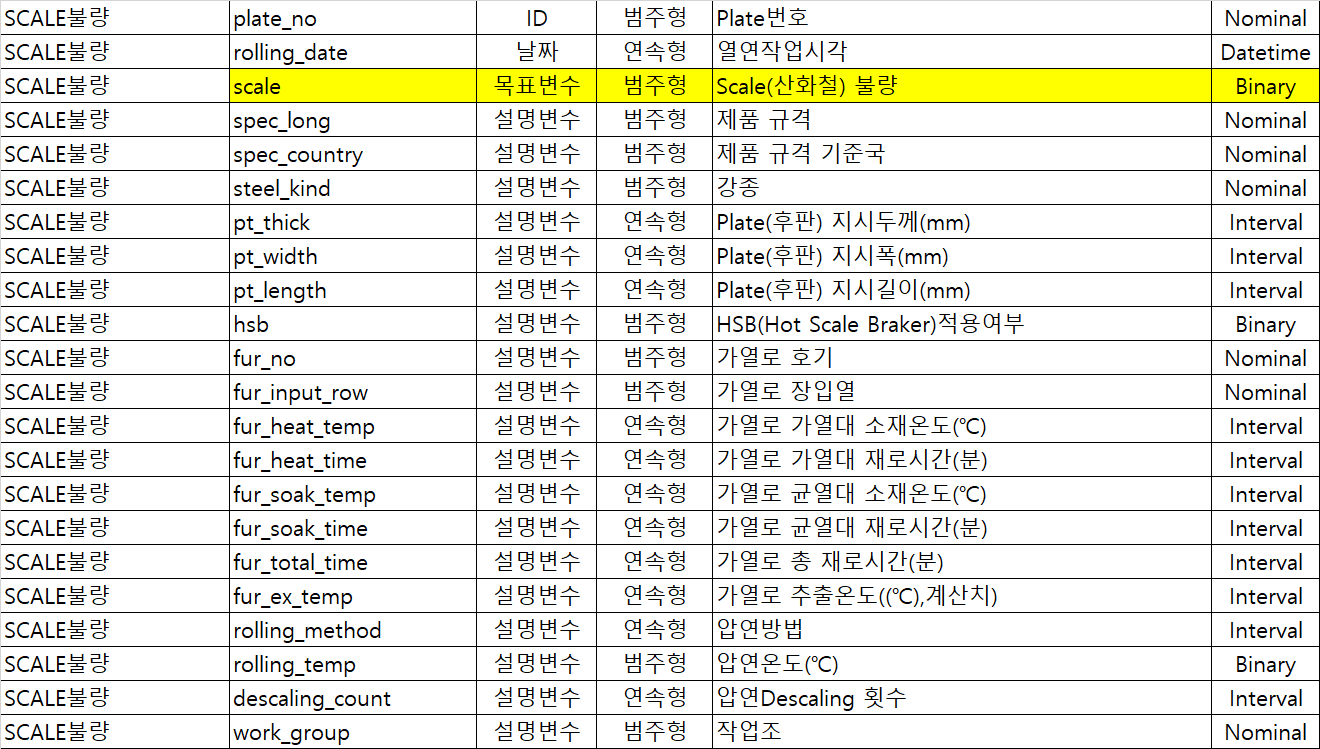

In [4]:
### 데이터 크기 파악하기
df.shape

(1000, 22)

- 목표변수 scale 제외하고 21개의 설명변수, 1000개의 데이터를 가지고 있다

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   plate_no         1000 non-null   object
 1   rolling_date     1000 non-null   object
 2   scale            1000 non-null   object
 3   spec_long        1000 non-null   object
 4   spec_country     1000 non-null   object
 5   steel_kind       1000 non-null   object
 6   pt_thick         1000 non-null   int64 
 7   pt_width         1000 non-null   int64 
 8   pt_length        1000 non-null   int64 
 9   hsb              1000 non-null   object
 10  fur_no           1000 non-null   object
 11  fur_input_row    1000 non-null   object
 12  fur_heat_temp    1000 non-null   int64 
 13  fur_heat_time    1000 non-null   int64 
 14  fur_soak_temp    1000 non-null   int64 
 15  fur_soak_time    1000 non-null   int64 
 16  fur_total_time   1000 non-null   int64 
 17  fur_ex_temp      1000 non-null   i

In [6]:
df.describe()

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_temp,descaling_count
count,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,26.78200,2831.900000,36788.200000,1157.245000,85.972000,1150.928000,71.720000,238.589000,1150.928000,934.637000,8.557000
std,18.13757,494.081478,13912.387116,21.245007,26.346297,17.344384,20.602137,38.194828,17.344384,96.598015,1.604158
min,12.00000,1800.000000,7900.000000,1103.000000,55.000000,1113.000000,35.000000,165.000000,1113.000000,0.000000,5.000000
25%,15.00000,2500.000000,26650.000000,1140.000000,66.000000,1135.750000,57.750000,210.000000,1135.750000,893.750000,8.000000
50%,19.00000,2800.000000,40400.000000,1159.000000,75.000000,1156.000000,66.000000,230.000000,1156.000000,948.000000,9.000000
75%,34.00000,3100.000000,49100.000000,1173.000000,102.250000,1164.000000,81.000000,263.000000,1164.000000,991.000000,10.000000
max,100.00000,4600.000000,54900.000000,1206.000000,158.000000,1185.000000,145.000000,362.000000,1185.000000,1078.000000,10.000000


- rolling temp가 0이 될 수 있는지? 이후 이상치 관련해서 확인 예정

In [7]:
scale_df = df.groupby('scale').size().reset_index().rename(columns={0:'size'})
scale_df['ratio'] = scale_df['size'] / sum(scale_df['size']) * 100
scale_df

,scale,size,ratio
0,불량,310,31.0
1,양품,690,69.0


In [8]:
df.columns

Index(['plate_no', 'rolling_date', 'scale', 'spec_long', 'spec_country',
       'steel_kind', 'pt_thick', 'pt_width', 'pt_length', 'hsb', 'fur_no',
       'fur_input_row', 'fur_heat_temp', 'fur_heat_time', 'fur_soak_temp',
       'fur_soak_time', 'fur_total_time', 'fur_ex_temp', 'rolling_method',
       'rolling_temp', 'descaling_count', 'work_group'],
      dtype='object')

# 기본 데이터 전처리
### 결측치 및 이상치 확인

- 위에서 df.info()로 확인해본 결과 결측치는 존재하지 않았음

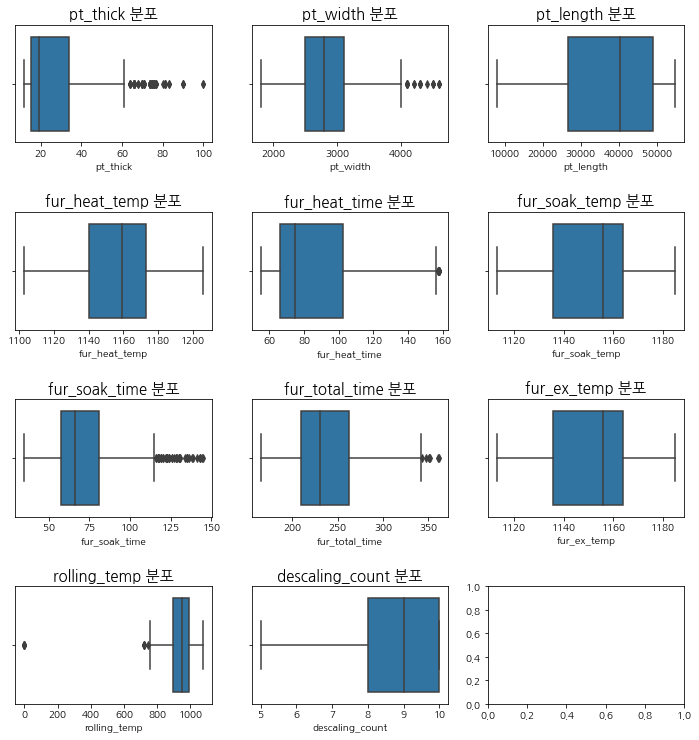

In [9]:
### 연속형 변수에서의 boxplot을 통한 이상치 확인
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10,10))
plt.tight_layout(w_pad=1, h_pad=5)
i = 1
for col in df.describe().columns.tolist():
    plt.subplot(4, 3, i) 
    sns.boxplot(data=df, x=col)
    plt.title(col + " 분포", fontsize=15)
    i += 1

- 위에서도 언급한 rolling_temp가 0인 경우가 이상치로 판단됨
- 조사 결과, 회사별 차이가 있지만 압연 온도의 적정 범위는 1000~1100도 사이라고 알려짐
- 해당 0으로 산정된 데이터들의 이상치 대체 예정

In [10]:
df[df.rolling_temp == 0].index

Int64Index([53, 221, 222, 598, 599, 600], dtype='int64')

In [11]:
rolling_temp_mean = df.rolling_temp.mean()
for i in df[df.rolling_temp == 0].index:
    df.loc[i, 'rolling_temp'] = rolling_temp_mean

In [12]:
df[df.index.isin([53, 221, 222, 598, 599, 600])]

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
53,PLT_1054,03JAN2023:16:22:29,양품,GL-E36-TM,독일,T,56,3800,11400,적용,...,1132,95,1128,80,244,1128,TMCP(온도제어),934.637,6,1조
221,PLT_1222,04JAN2023:19:44:09,양품,JS-SM490YB,일본,C,16,2200,43600,적용,...,1163,57,1166,67,228,1166,CR(제어압연),934.637,10,2조
222,PLT_1223,04JAN2023:19:56:39,양품,JS-SM490YB,일본,C,16,2200,43600,적용,...,1169,64,1164,61,188,1164,CR(제어압연),934.637,10,2조
598,PLT_1599,07JAN2023:11:40:51,양품,PILAC-BT33,한국,T,81,2100,12900,적용,...,1133,89,1122,59,229,1122,CR(제어압연),934.637,6,3조
599,PLT_1600,07JAN2023:11:52:00,양품,PILAC-BT33,한국,T,81,2100,13200,적용,...,1130,92,1124,61,210,1124,CR(제어압연),934.637,6,3조
600,PLT_1601,07JAN2023:11:59:10,양품,NV-D32-TM,영국,T,40,2500,23600,적용,...,1119,109,1117,76,260,1117,TMCP(온도제어),934.637,6,3조


- 결측치, 이상치 처리 완료

- 또한, plate_no는 필요 없다고 판단, 고유값이기 때문이다.
- rolling_date 같은 경우, 시간 변수로 이번 분석의 목표는 후판 공정 과정에서의 데이터 분석으로 시간 데이터는 큰 의미가 없다고 판단하여 제거 예정

In [13]:
### 전처리 전에 근무 조마다 특정 교대 시간이 있다고 가정하고 파악
for group in df.work_group.unique().tolist():
    print(group, list(set([x.split(':')[1] for x in df[df.work_group==group]['rolling_date'].tolist()])))

1조 ['09', '12', '10', '13', '18', '07', '16', '14', '17', '11', '08', '15']
2조 ['02', '03', '21', '01', '19', '22', '05', '20', '23', '06', '04', '00']
3조 ['09', '12', '10', '13', '18', '07', '16', '14', '17', '11', '08', '15']
4조 ['02', '03', '21', '01', '19', '22', '05', '20', '23', '06', '04', '00']


In [14]:
### 근무시간 별 추가 컬럼 생성
df['교대'] = df.rolling_date.apply(lambda x: '1교대' if x.split(':')[1] in ['07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18'] else '2교대')
df.head()

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group,교대
0,PLT_1001,03JAN2023:07:07:53,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,116,1133,59,259,1133,TMCP(온도제어),934.0,8,1조,1교대
1,PLT_1002,03JAN2023:07:21:22,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,122,1135,53,238,1135,TMCP(온도제어),937.0,8,1조,1교대
2,PLT_1003,03JAN2023:07:31:15,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,116,1121,55,258,1121,TMCP(온도제어),889.0,8,1조,1교대
3,PLT_1004,03JAN2023:07:41:01,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,125,1127,68,266,1127,TMCP(온도제어),885.0,8,1조,1교대
4,PLT_1005,03JAN2023:07:52:40,양품,BV-EH36-TM,프랑스,T,38,3100,13300,적용,...,134,1128,48,246,1128,TMCP(온도제어),873.0,8,1조,1교대


In [15]:
df.drop(['plate_no','rolling_date'], axis=1, inplace=True)
df.head()

,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,...,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group,교대
0,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,1호기,1열,...,116,1133,59,259,1133,TMCP(온도제어),934.0,8,1조,1교대
1,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,1호기,2열,...,122,1135,53,238,1135,TMCP(온도제어),937.0,8,1조,1교대
2,양품,NV-E36-TM,영국,T,33,3600,19200,적용,2호기,1열,...,116,1121,55,258,1121,TMCP(온도제어),889.0,8,1조,1교대
3,양품,NV-E36-TM,영국,T,33,3600,19200,적용,2호기,2열,...,125,1127,68,266,1127,TMCP(온도제어),885.0,8,1조,1교대
4,양품,BV-EH36-TM,프랑스,T,38,3100,13300,적용,3호기,1열,...,134,1128,48,246,1128,TMCP(온도제어),873.0,8,1조,1교대


In [16]:
df['scale'] = df['scale'].apply(lambda x: 0 if x == '양품' else 1)
df.head()

,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,...,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group,교대
0,0,AB/EH32-TM,미국,T,32,3700,15100,적용,1호기,1열,...,116,1133,59,259,1133,TMCP(온도제어),934.0,8,1조,1교대
1,0,AB/EH32-TM,미국,T,32,3700,15100,적용,1호기,2열,...,122,1135,53,238,1135,TMCP(온도제어),937.0,8,1조,1교대
2,0,NV-E36-TM,영국,T,33,3600,19200,적용,2호기,1열,...,116,1121,55,258,1121,TMCP(온도제어),889.0,8,1조,1교대
3,0,NV-E36-TM,영국,T,33,3600,19200,적용,2호기,2열,...,125,1127,68,266,1127,TMCP(온도제어),885.0,8,1조,1교대
4,0,BV-EH36-TM,프랑스,T,38,3100,13300,적용,3호기,1열,...,134,1128,48,246,1128,TMCP(온도제어),873.0,8,1조,1교대


# VF 탐색

- 간단한 모델 기반 변수 중요도 우선 파악

In [17]:
dt_base = DecisionTreeClassifier()
df_dummy = pd.get_dummies(df)
df_y = df_dummy['scale']
df_x = df_dummy.drop('scale', axis = 1)
train_x, test_x, train_y, test_y = train_test_split(df_x, df_y, test_size=0.3)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape, )

(700, 101) (300, 101) (700,) (300,)


In [18]:
dt_base.fit(train_x, train_y)
df_importance = pd.DataFrame()
df_importance['Feature'] = test_x.columns
df_importance['Importance'] = dt_base.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
9,rolling_temp,0.495
86,hsb_미적용,0.185
5,fur_soak_temp,0.178
0,pt_thick,0.092
10,descaling_count,0.022
...,...,...
35,spec_long_GL-D36-TM,0.000
34,spec_long_GL-A36-TM,0.000
33,spec_long_GL-A32-TM,0.000
32,spec_long_GL-A32,0.000


Text(0, 0.5, '변수')

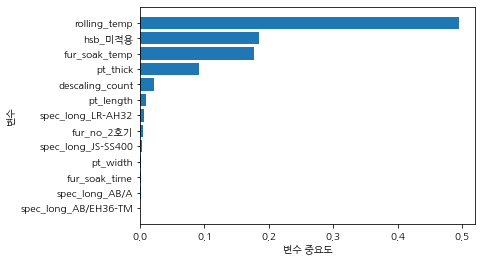

In [19]:
### 0인 값이 많기 때문에 해당 값들을 제거한 그래프만 확인
df_importance.sort_values("Importance", ascending=True, inplace=True)
df_importance = df_importance[df_importance.Importance > 0]
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

- 간단한 변수 중요도 분석 결과:
- roling_temp, hsb, fur_soak_temp, pt_thick, descaling_count가 영향을 많이 주는 변수다.
- 공정 과정에서 추가 공정 횟수 및 공정 온도가 큰 영향을 끼치는걸 알 수 있다.

# 데이터 EDA

### 설명 변수 - 파생 변수 생성 혹은 필요 없는 컬럼 삭제

In [20]:
df[['fur_heat_temp', 'fur_soak_temp','fur_ex_temp']]

,fur_heat_temp,fur_soak_temp,fur_ex_temp
0,1144,1133,1133
1,1144,1135,1135
2,1129,1121,1121
3,1152,1127,1127
4,1140,1128,1128
...,...,...,...
995,1142,1151,1151
996,1142,1151,1151
997,1169,1163,1163
998,1169,1163,1163


In [21]:
### fur_soak_temp랑 fur_ex_temp랑 완전 동일하기 때문에 한 컬럼 삭제 가능
(df['fur_soak_temp'] == df['fur_ex_temp']).sum()

1000

In [22]:
df.drop('fur_ex_temp', axis=1, inplace=True)

- fur_ex_temp라는 변수를 제거함

In [23]:
### total time은 가열로 총 재로시간인데 가열대 재로시간 및 균열대 재로시간의 합과 차이가 있다. 
((df['fur_heat_time'] + df['fur_soak_time']) == df['fur_total_time']).sum()

0

In [24]:
### 약 평균 80.9분의 잔여 시간이 발생하는데 해당 시간의 이유는 모르지만 해당 값에 따라 불량률에 차이가 있는 지 궁금하여 분석 예정
df['heat+soak_time'] = df['fur_heat_time'] + df['fur_soak_time']
df['fur_remain_time'] = df['fur_total_time'] - df['heat+soak_time']
df[['fur_heat_time', 'fur_soak_time', 'fur_total_time', 'heat+soak_time', 'fur_remain_time']]

,fur_heat_time,fur_soak_time,fur_total_time,heat+soak_time,fur_remain_time
0,116,59,259,175,84
1,122,53,238,175,63
2,116,55,258,171,87
3,125,68,266,193,73
4,134,48,246,182,64
...,...,...,...,...,...
995,55,86,203,141,62
996,55,86,209,141,68
997,65,77,227,142,85
998,65,77,204,142,62


<AxesSubplot:xlabel='fur_remain_time', ylabel='fur_soak_temp'>

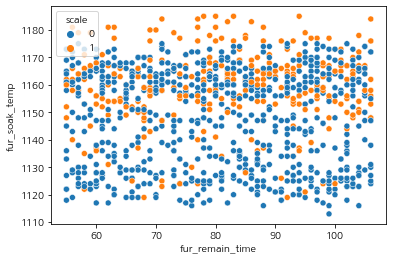

In [25]:
import seaborn as sns
sns.scatterplot(data=df, x = 'fur_remain_time', y = 'fur_soak_temp', hue='scale')

In [26]:
df.drop(['fur_remain_time','heat+soak_time'], axis=1, inplace=True)

In [27]:
df

,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,work_group,교대
0,0,AB/EH32-TM,미국,T,32,3700,15100,적용,1호기,1열,1144,116,1133,59,259,TMCP(온도제어),934.0,8,1조,1교대
1,0,AB/EH32-TM,미국,T,32,3700,15100,적용,1호기,2열,1144,122,1135,53,238,TMCP(온도제어),937.0,8,1조,1교대
2,0,NV-E36-TM,영국,T,33,3600,19200,적용,2호기,1열,1129,116,1121,55,258,TMCP(온도제어),889.0,8,1조,1교대
3,0,NV-E36-TM,영국,T,33,3600,19200,적용,2호기,2열,1152,125,1127,68,266,TMCP(온도제어),885.0,8,1조,1교대
4,0,BV-EH36-TM,프랑스,T,38,3100,13300,적용,3호기,1열,1140,134,1128,48,246,TMCP(온도제어),873.0,8,1조,1교대
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,BV-A,프랑스,C,19,3400,41500,적용,1호기,2열,1142,55,1151,86,203,CR(제어압연),948.0,10,4조,2교대
996,0,LR-A,영국,C,19,3400,41500,적용,1호기,2열,1142,55,1151,86,209,CR(제어압연),948.0,10,4조,2교대
997,0,AB/AH32,미국,C,17,3400,43700,적용,2호기,2열,1169,65,1163,77,227,CR(제어압연),948.0,10,4조,2교대
998,0,NV-A32,영국,C,17,3400,43700,적용,2호기,2열,1169,65,1163,77,204,CR(제어압연),948.0,10,4조,2교대


- 잔여 시간에 따른 불량 분포를 확인해본 결과, 유의미한 특징이 보이지 않아서 해당 컬럼은 사용하지 않는다.

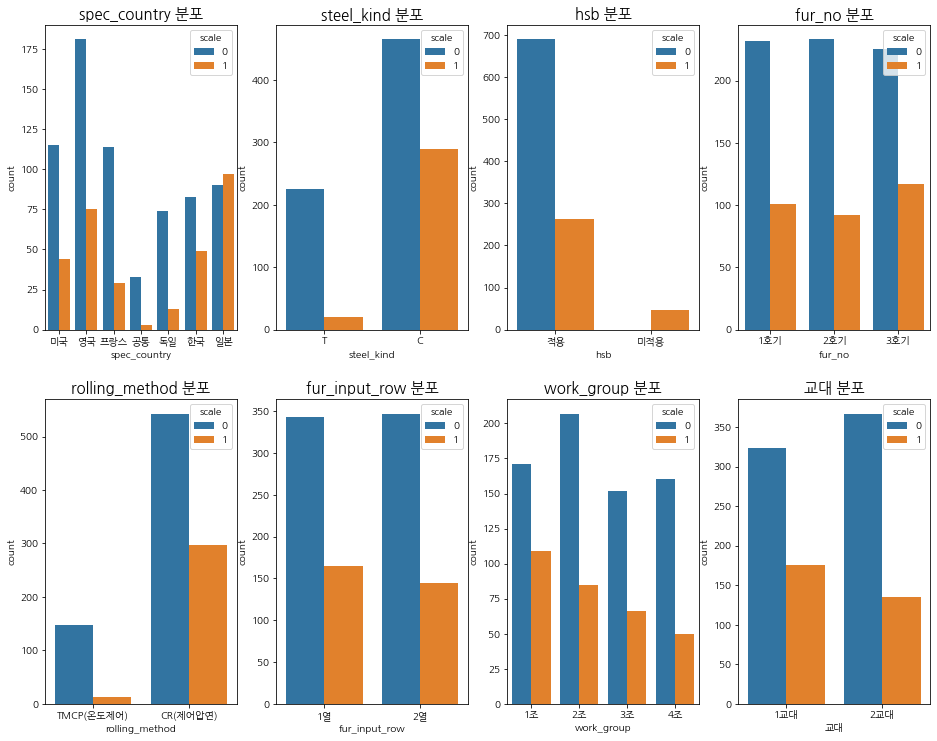

In [28]:
## 전체 범주형 변수들의 분포 확인
cols = ['spec_country', 'steel_kind', 'hsb', 'fur_no', 'rolling_method', 'fur_input_row', 'work_group', '교대']
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(13,10))
plt.tight_layout(w_pad=1, h_pad=5)
i = 1
for col in cols:
    plt.subplot(2, 4, i) 
    sns.countplot(data=df, x=col, hue='scale')
    plt.title(col + " 분포", fontsize=15)
    i += 1

In [29]:
for col in cols:
    print(col)
    fun_print_cross_tab(df, col)
    print()

spec_country
spec_country  공통  독일   미국   영국  일본  프랑스  한국
scale                                      
0             33  74  115  181  90  114  83
1              3  13   44   75  97   29  49

spec_country     공통     독일     미국     영국     일본    프랑스     한국
scale                                                        
0             0.917  0.851  0.723  0.707  0.481  0.797  0.629
1             0.083  0.149  0.277  0.293  0.519  0.203  0.371

steel_kind
steel_kind    C    T
scale               
0           465  225
1           290   20

steel_kind      C      T
scale                   
0           0.616  0.918
1           0.384  0.082

hsb
hsb    미적용   적용
scale          
0        0  690
1       47  263

hsb    미적용     적용
scale            
0      0.0  0.724
1      1.0  0.276

fur_no
fur_no  1호기  2호기  3호기
scale                
0       232  233  225
1       101   92  117

fur_no    1호기    2호기    3호기
scale                      
0       0.697  0.717  0.658
1       0.303  0.283  0.342

rolling_metho

호열     1호기1열  1호기2열  2호기1열  2호기2열  3호기1열  3호기2열
scale                                          
0        101    131    124    109    118    107
1         57     44     48     44     60     57

호열     1호기1열  1호기2열  2호기1열  2호기2열  3호기1열  3호기2열
scale                                          
0      0.639  0.749  0.721  0.712  0.663  0.652
1      0.361  0.251  0.279  0.288  0.337  0.348


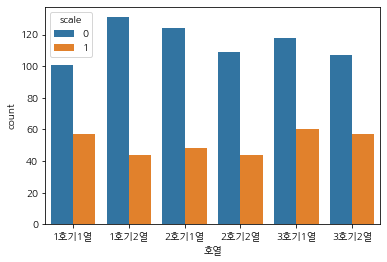

In [30]:
df['호열'] = df.fur_no + df.fur_input_row
sns.countplot(data=df, x='호열', hue='scale')
fun_print_cross_tab(df,'호열')

- HSB 적용 미적용 중에 미적용일 경우 불량만 발생한다. 즉, HSB는 공정에서 무조건 적용해야 한다.
-	 한국 규격에서 발생하는 불량률이 높으며, 일본은 초과한다.
- 각 규격 국가별로 분류해서 분석한 결과, 일본은 불량률이 양품일 확률보다 매우 높기 때문에 해당 데이터들만 따로 추출해서 분석 진행
-	강종이 탄소인 제품들의 불량률이 매우 높기 때문에 해당 데이터들만 따로 추출해서 분석 진행
-	Rolling-method가 제어압연일 경우만 따로 분리해서 진행할 예정
-	기타 범주형 설명 변수들은 비슷한 불량률을 가지고 있다고 파악.
- 추가로 호기별열로 나눴을 때의 데이터를 확인해본 결과, 유의미한 불량률 차이는 없는걸로 판단


[Text(0, 0, 'AB/EH32-TM'),
 Text(1, 0, 'NV-E36-TM'),
 Text(2, 0, 'BV-EH36-TM'),
 Text(3, 0, 'AB/EH36-TM'),
 Text(4, 0, 'COMMON'),
 Text(5, 0, 'BV-AH32-TM'),
 Text(6, 0, 'GL-E32-TM'),
 Text(7, 0, 'GL-E36-TM'),
 Text(8, 0, 'BV-EH32-TM'),
 Text(9, 0, 'KS-HSB600'),
 Text(10, 0, 'LR-EH36-TM'),
 Text(11, 0, 'BV-B'),
 Text(12, 0, 'AB/B'),
 Text(13, 0, 'LR-B'),
 Text(14, 0, 'JS-SM490YB'),
 Text(15, 0, 'KR-B'),
 Text(16, 0, 'LR-A'),
 Text(17, 0, 'JS-SM490A'),
 Text(18, 0, 'KS-SM400B'),
 Text(19, 0, 'JS-SM400B'),
 Text(20, 0, 'KS-SS400'),
 Text(21, 0, 'KR-A'),
 Text(22, 0, 'JS-SS400'),
 Text(23, 0, 'NV-A'),
 Text(24, 0, 'KS-SM400A'),
 Text(25, 0, 'KS-SM490B'),
 Text(26, 0, 'V42JBN3'),
 Text(27, 0, 'AB/A'),
 Text(28, 0, 'A516-60'),
 Text(29, 0, 'BV-AH32'),
 Text(30, 0, 'JS-SM490YA'),
 Text(31, 0, 'AB/AH32'),
 Text(32, 0, 'GL-A32'),
 Text(33, 0, 'LR-AH32'),
 Text(34, 0, 'CCS-B'),
 Text(35, 0, 'NV-B'),
 Text(36, 0, 'NV-A32'),
 Text(37, 0, 'KS-SM490A'),
 Text(38, 0, 'GL-A'),
 Text(39, 0, 'NK-KA32'),

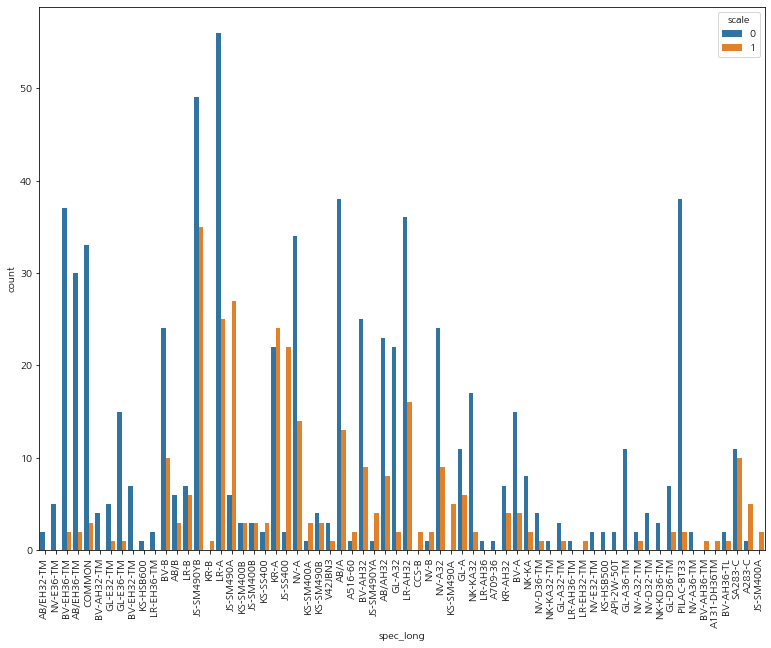

In [31]:
### 규격별 불량률 확인
fig, axes = plt.subplots(figsize=(13,10))
sns.countplot(data = df, x='spec_long', hue='scale')
axes.set_xticklabels(axes.get_xticklabels(),rotation = 90)
# fun_plot_hist(df, 'spec_long')

In [32]:
### 불량률이 0%인 규격 확인
all_ok = list(set(df[df.scale == 0].spec_long.unique().tolist()) - set(df[df.scale == 1].spec_long.unique().tolist()))
all_no = list(set(df[df.scale == 1].spec_long.unique().tolist()) - set(df[df.scale == 0].spec_long.unique().tolist()))
df_okno = df.copy()
df_okno = df_okno[(df_okno.spec_long.isin(all_ok))|(df_okno.spec_long.isin(all_no))]
df_okno['spec_check'] = df_okno.spec_long.apply(lambda x: '100%양품' if x in all_ok else '100%불량')
df_okno

,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,...,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,work_group,교대,호열,spec_check
0,0,AB/EH32-TM,미국,T,32,3700,15100,적용,1호기,1열,...,1133,59,259,TMCP(온도제어),934.0,8,1조,1교대,1호기1열,100%양품
1,0,AB/EH32-TM,미국,T,32,3700,15100,적용,1호기,2열,...,1135,53,238,TMCP(온도제어),937.0,8,1조,1교대,1호기2열,100%양품
2,0,NV-E36-TM,영국,T,33,3600,19200,적용,2호기,1열,...,1121,55,258,TMCP(온도제어),889.0,8,1조,1교대,2호기1열,100%양품
3,0,NV-E36-TM,영국,T,33,3600,19200,적용,2호기,2열,...,1127,68,266,TMCP(온도제어),885.0,8,1조,1교대,2호기2열,100%양품
16,0,BV-AH32-TM,프랑스,T,30,1900,34800,적용,1호기,2열,...,1120,65,289,TMCP(온도제어),926.0,8,1조,1교대,1호기2열,100%양품
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,1,KS-SM490A,한국,C,20,2500,51100,적용,1호기,1열,...,1169,44,249,CR(제어압연),1025.0,8,3조,1교대,1호기1열,100%불량
808,1,KS-SM490A,한국,C,20,1900,34100,적용,3호기,2열,...,1158,73,249,CR(제어압연),1018.0,8,4조,2교대,3호기2열,100%불량
859,1,JS-SM400A,일본,C,100,2300,9500,적용,3호기,2열,...,1150,52,219,CR(제어압연),1050.0,6,3조,1교대,3호기2열,100%불량
860,1,JS-SM400A,일본,C,100,2300,9500,적용,1호기,1열,...,1137,61,206,CR(제어압연),1037.0,6,3조,1교대,1호기1열,100%불량


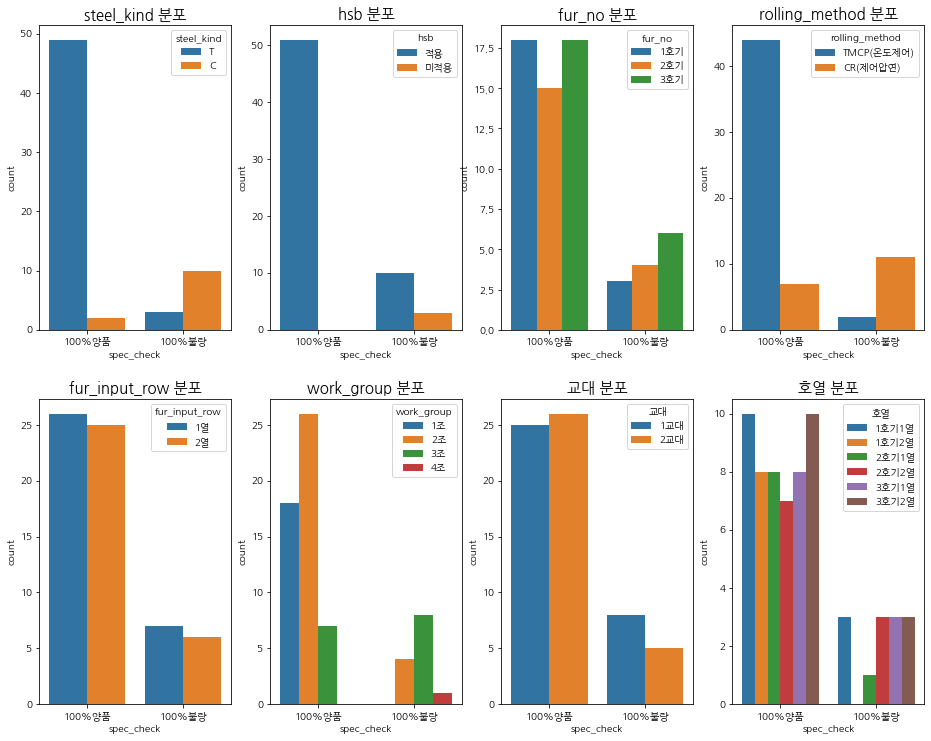

In [33]:
## 전체 범주형 변수들의 분포 확인
cols = ['steel_kind', 'hsb', 'fur_no', 'rolling_method', 'fur_input_row', 'work_group','교대', 
       '호열']
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(13,10))
plt.tight_layout(w_pad=1, h_pad=5)
i = 1
for col in cols:
    plt.subplot(2, 4, i) 
    sns.countplot(data=df_okno, x='spec_check', hue=col)
    plt.title(col + " 분포", fontsize=15)
    i += 1

- 결론적으로는 각 규격마다의 기준 국가, 내부 함량 등이 다 다르기 때문에 특정 규격이 불량률이 높다고 판단은 되나 전체적인 불량률을 판단하기에는 힘들다고 생각되서 제거 예정
- 특정 규격은 불량품이 아예 없고 특정 규격은 불량률이 100%다. 
- 어떤 컬럼들이 해당되는지 확인 예정
    - 100% 양품이었던 규격들은 무조건 HSB 적용이 되었다.
    - 모든 조가 돌아가면서 모든 제품을 담당하는 것이 아니다. 
    - 1호기 2열에서도 100% 불량인 규격들을 공정한 적이 없다.

In [34]:
### 국가 규격별 유의미한 차이 있는지 검정
### 일본의 불량률이 현저하게 차이가 있다고 판단해서 근거 파악
check_difference(df,'spec_country')

chi-squared statistic: 68.38385440143149
p-value: 8.766804557877507e-13
degrees of freedom: 6
expected frequencies:
 [[ 24.84  60.03 109.71 176.64 129.03  98.67  91.08]
 [ 11.16  26.97  49.29  79.36  57.97  44.33  40.92]]


- H_0이 국가별 불량 여부에 유의미한 차이가 있다.
- p-value 값이 유의수준보다 작기 때문에 해당 귀무가설을 기각하고 세부적으로 일본 규격에 해당하는 데이터 추가 분석 예정

In [35]:
### 강종별 유의미한 차이가 있는지 검정
check_difference(df,'steel_kind')

chi-squared statistic: 77.7104243330205
p-value: 1.1931000837493562e-18
degrees of freedom: 1
expected frequencies:
 [[520.95 169.05]
 [234.05  75.95]]


- H_0이 강종별 불량 여부에 유의미한 차이가 있다
- p-value 값이 유의수준보다 작기 때문에 해당 귀무가설을 기각하고 세부적으로 탄소 강종에 해당하는 데이터 추가 분석 예정

In [36]:
### HSB 적용 유무에 유의미한 차이가 있는지 검정
### 그래프 상으로도 분명한 차이가 있는지 확인했음
check_difference(df,'hsb')

chi-squared statistic: 106.4133937362546
p-value: 5.985184936341528e-25
degrees of freedom: 1
expected frequencies:
 [[ 32.43 657.57]
 [ 14.57 295.43]]


- hsb 적용 여부에 큰 차이가 있음을 증명

In [37]:
### 호열 컬럼에 호기와 열에 관한 데이터를 합병했기 때문에 해당 컬럼으로 확인 예정
check_difference(df, '호열')

chi-squared statistic: 7.5305591464631805
p-value: 0.18407582444483742
degrees of freedom: 5
expected frequencies:
 [[109.02 120.75 118.68 105.57 122.82 113.16]
 [ 48.98  54.25  53.32  47.43  55.18  50.84]]


- 해당 컬럼은 H_0을 채택하여 호기 열마다의 차이가 없다고 판단
- 즉, 제거할 예정

In [38]:
### rolling_method(압연 방식)에 따른 유의미한 차이가 있는지 검정
check_difference(df, 'rolling_method')

chi-squared statistic: 45.33194472272313
p-value: 1.6631417719483243e-11
degrees of freedom: 1
expected frequencies:
 [[579.6 110.4]
 [260.4  49.6]]


- 해당 컬럼은 H_0을 채택하고 차이가 있다는 것을 알 수 있음

In [39]:
### 근무조 및 교대에 있어서 유의미한 차이가 있는지 검정
check_difference(df,'work_group')

chi-squared statistic: 13.84622170632565
p-value: 0.0031221225267359233
degrees of freedom: 3
expected frequencies:
 [[193.2  201.48 150.42 144.9 ]
 [ 86.8   90.52  67.58  65.1 ]]


In [40]:
check_difference(df,'교대')

chi-squared statistic: 7.570282882356883
p-value: 0.00593384703509422
degrees of freedom: 1
expected frequencies:
 [[343.62 346.38]
 [154.38 155.62]]


- 근무조, 교대 시간 등에 따른 유의미한 차이가 있다고 본다. 

#### 국가 규격별 데이터 세분화 확인 - 일본 규격

In [41]:
df_japan = df[df.spec_country=='일본']
df_japan.reset_index(drop=True, inplace=True)
df_japan.shape

(187, 21)

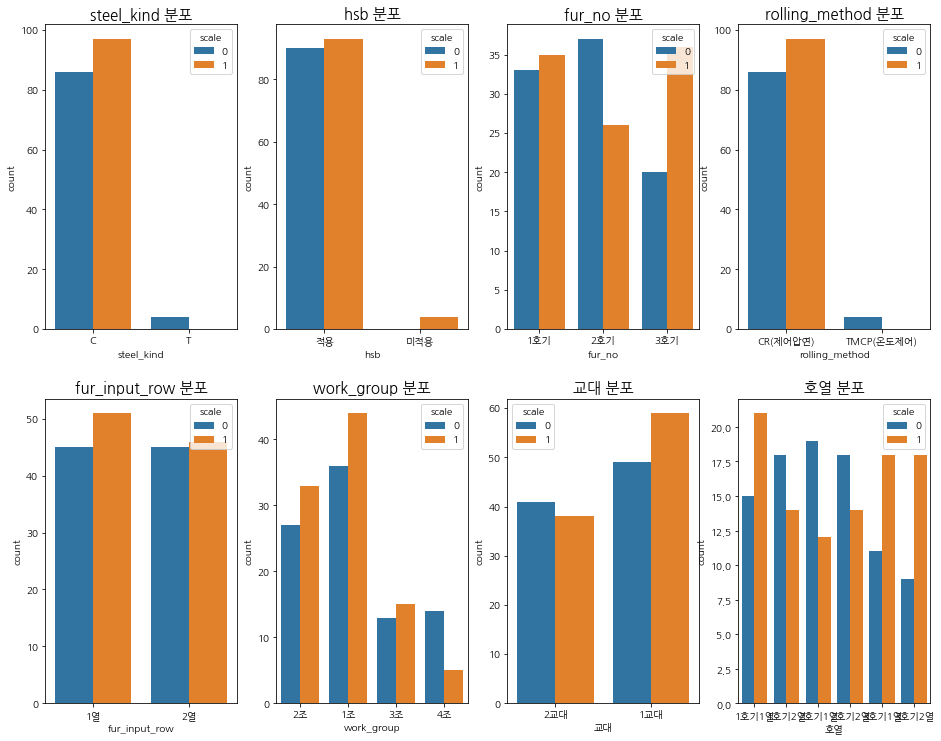

In [42]:
## 전체 범주형 변수들의 분포 확인
cols = ['steel_kind', 'hsb', 'fur_no', 'rolling_method', 'fur_input_row', 'work_group', '교대',
       '호열']
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(13,10))
plt.tight_layout(w_pad=1, h_pad=5)
i = 1
for col in cols:
    plt.subplot(2, 4, i) 
    sns.countplot(data=df_japan, x=col, hue='scale')
    plt.title(col + " 분포", fontsize=15)
    i += 1

In [43]:
### 각 범주별 유의미한 차이 있는지 파악
for col in cols:
    cross_tab = pd.crosstab(df_japan["scale"], df_japan[col])

    # 카이제곱 검정 실행
    chi2, pval, dof, expected = chi2_contingency(cross_tab)
    if pval < 0.05:
        print('{}은 유의미한 차이가 있다'.format(col))

fur_no은 유의미한 차이가 있다


- 분포 확인 결과, 탄소 강종에서 높은 불량률을 보였다. 티타늄 공정에 있어서는 분포도 적을뿐만 아니라 불량률은 0이다.
- 3호기 같은 경우, 너무 높은 불량률을 가지고 있고 열에 상관없이 높다.
- 1호기 같은 경우는 1호기 1열의 불량률이 매우 높다.
    - 1호기 1열의 다른 데이터(온도, 시간 등)의 분포가 다른 호열과의 분포와 같은지 파악할 필요를 느낌
    - 특히 비교적 안정적인 2호기의 데이터와 비교할 필요를 느낀다

- 또한 rolling_method에 있어서도 강종과 같은 분포를 보이는데 해당 부분은 티타늄 공정이 온도제어로 진행하는 것인지에 대한 추가 확인 예정이다.

- 조별로도 큰 차이를 보이는데 4조의 불량률이 비교적 현저하게 차이가 나기 때문에 해당 조의 데이터와 다른 조들과의 데이터를 분석하는 것도 유의미하다고 판단한다.

#### 추가 분석
- 강종 및 압연 방식은 따로 분리해서 확인 예정이라 일본 규격 데이터에서는 확인하지 않을 예정이고, 각 호기 각 열마다의 데이터 / 조별 데이터로 나누어서 확인해보려고 한다.

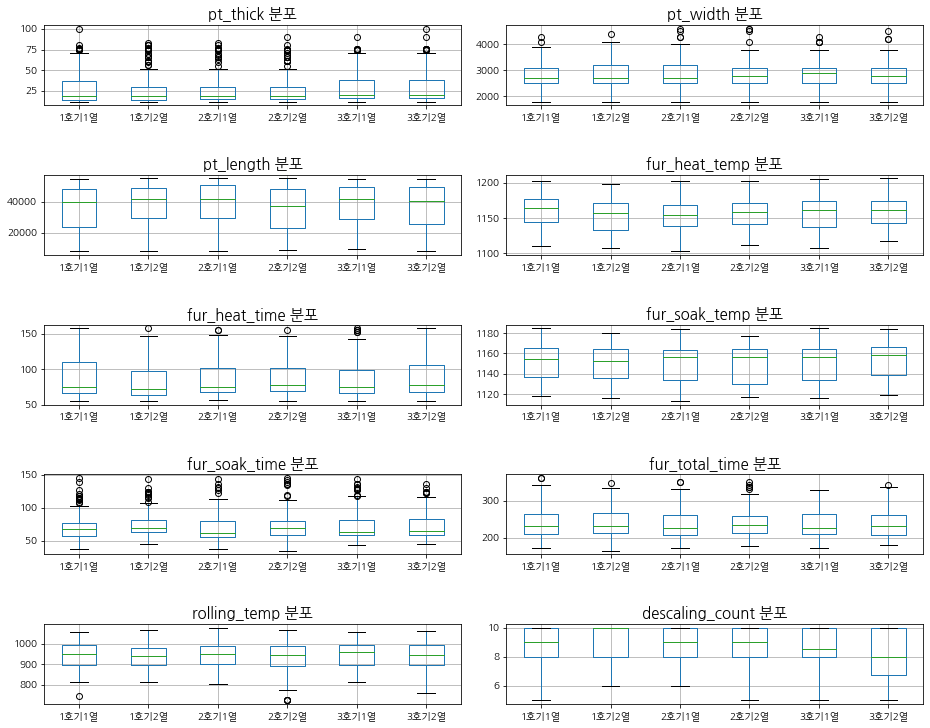

In [44]:
### 각 호기 각 열별 확인
%matplotlib inline
df_line = {}
checklst = ['pt_thick','pt_width','pt_length','fur_heat_temp','fur_heat_time','fur_soak_temp',
            'fur_soak_time','fur_total_time','rolling_temp','descaling_count']

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(13,10))
plt.tight_layout(w_pad=1, h_pad=5)
i = 1
for col in checklst:
    plt.subplot(5, 2, i) 
    for line in df.호열.unique().tolist():
        df_l = df[df.호열 == line][col]
        df_l.reset_index(drop=True, inplace=True)
        df_line[line] = df_l

    new_line = pd.DataFrame(df_line)

    new_line.boxplot(new_line.columns.tolist())
    plt.title(col + " 분포", fontsize=15)
    i += 1
    


- 그래프 상으로 확인했을 때 유의미한 차이를 보이는 것은 descaling_count 분포에서 3호기 2열이 다른 것보다 분포가 다르다는 것을 확인할 수 있었다.

#### 강종이 탄소인 데이터만 분리해서 분석

In [45]:
df_c = df[df.steel_kind == 'C']
df_c.reset_index(drop=True, inplace=True)
df_c.head()

,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,...,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,work_group,교대,호열
0,0,BV-B,프랑스,C,20,3600,39300,적용,3호기,1열,...,76,1126,118,297,CR(제어압연),934.0,8,2조,2교대,3호기1열
1,0,BV-B,프랑스,C,20,3600,39500,적용,3호기,2열,...,68,1132,104,235,CR(제어압연),911.0,8,2조,2교대,3호기2열
2,0,AB/B,미국,C,17,3400,39600,적용,2호기,2열,...,71,1130,112,240,CR(제어압연),935.0,10,2조,2교대,2호기2열
3,0,LR-B,영국,C,17,3400,39600,적용,2호기,2열,...,71,1130,112,287,CR(제어압연),935.0,10,2조,2교대,2호기2열
4,0,JS-SM490YB,일본,C,14,3300,51200,적용,1호기,1열,...,80,1131,117,286,CR(제어압연),915.0,10,2조,2교대,1호기1열


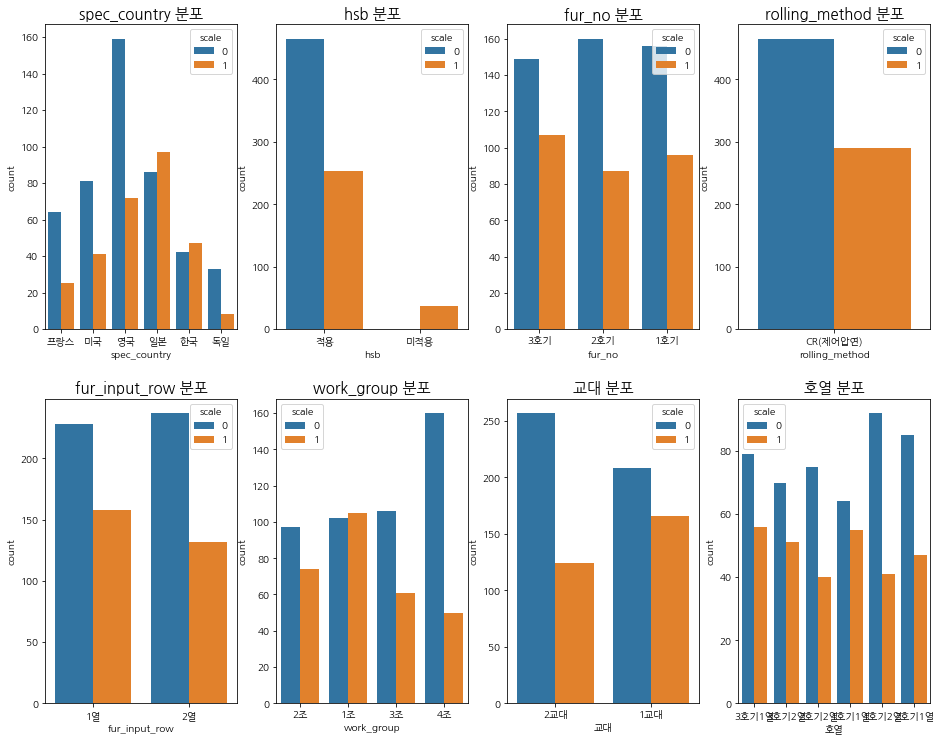

In [46]:
## 전체 범주형 변수들의 분포 확인
cols = ['spec_country', 'hsb', 'fur_no', 'rolling_method', 'fur_input_row', 'work_group', '교대',
       '호열']
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(13,10))
plt.tight_layout(w_pad=1, h_pad=5)
i = 1
for col in cols:
    plt.subplot(2, 4, i) 
    sns.countplot(data=df_c, x=col, hue='scale')
    plt.title(col + " 분포", fontsize=15)
    i += 1

In [47]:
### 각 범주별 유의미한 차이 있는지 파악
for col in cols:
    cross_tab = pd.crosstab(df_c["scale"], df_c[col])

    # 카이제곱 검정 실행
    chi2, pval, dof, expected = chi2_contingency(cross_tab)
    if pval < 0.05:
        print('{}은 유의미한 차이가 있다'.format(col))

spec_country은 유의미한 차이가 있다
hsb은 유의미한 차이가 있다
work_group은 유의미한 차이가 있다
교대은 유의미한 차이가 있다


- 해당 그래프를 통해 탄소 강종 제품은 모두 CR(제어압연)을 통해 진행된다는 점을 파악할 수 있음
- 강종에서 확인했을 때도 4조의 불량률이 다른 조보다 현저히 낮다는 것을 알 수 있음
    - 각 조마다 불량률이 높은 철강 규격이나 강종이 있다고 판단됨(추가 분석 가능)

#### 제어 압연일 경우 분리해서 확인

In [48]:
df_cr = df[df.rolling_method =='CR(제어압연)']
df_cr.reset_index(inplace=True, drop=True)
df_cr.head()

,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,...,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,work_group,교대,호열
0,0,COMMON,공통,T,38,3100,16200,적용,2호기,2열,...,119,1124,73,261,CR(제어압연),881.0,8,1조,1교대,2호기2열
1,0,COMMON,공통,T,38,3100,16200,적용,3호기,1열,...,134,1123,58,259,CR(제어압연),869.0,8,1조,1교대,3호기1열
2,0,COMMON,공통,T,38,3100,16200,적용,1호기,1열,...,125,1127,62,286,CR(제어압연),820.0,8,1조,1교대,1호기1열
3,1,COMMON,공통,T,38,3100,16200,적용,3호기,2열,...,120,1125,68,259,CR(제어압연),1057.0,8,1조,1교대,3호기2열
4,0,COMMON,공통,T,30,1900,34800,적용,1호기,2열,...,130,1120,65,282,CR(제어압연),926.0,8,1조,1교대,1호기2열


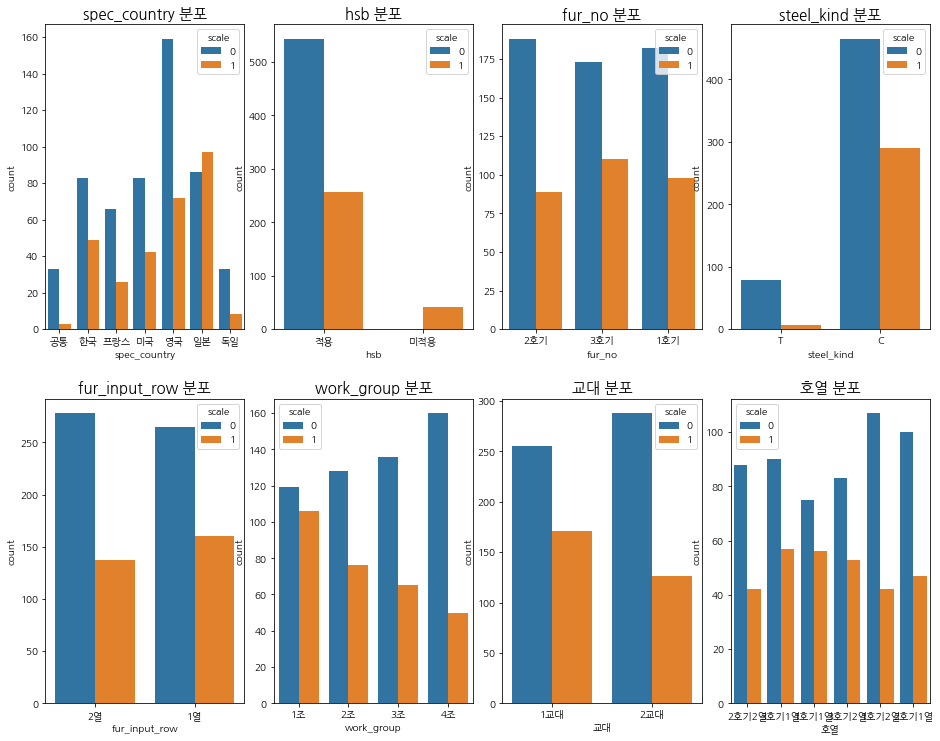

In [49]:
## 전체 범주형 변수들의 분포 확인
cols = ['spec_country', 'hsb', 'fur_no', 'steel_kind', 'fur_input_row', 'work_group', '교대',
       '호열']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(13,10))
plt.tight_layout(w_pad=1, h_pad=5)
i = 1
for col in cols:
    plt.subplot(2, 4, i) 
    sns.countplot(data=df_cr, x=col, hue='scale')
    plt.title(col + " 분포", fontsize=15)
    i += 1

In [50]:
### 각 범주별 유의미한 차이 있는지 파악
for col in cols:
    cross_tab = pd.crosstab(df_cr["scale"], df_cr[col])

    # 카이제곱 검정 실행
    chi2, pval, dof, expected = chi2_contingency(cross_tab)
    if pval < 0.05:
        print('{}은 유의미한 차이가 있다'.format(col))

spec_country은 유의미한 차이가 있다
hsb은 유의미한 차이가 있다
steel_kind은 유의미한 차이가 있다
work_group은 유의미한 차이가 있다
교대은 유의미한 차이가 있다


### 기타 변수 추가 확인

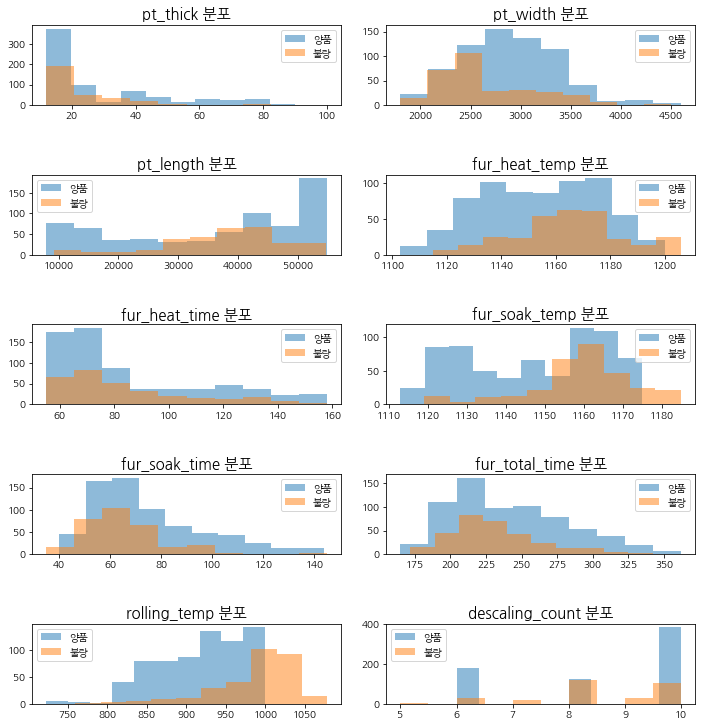

In [51]:
### 연속형 변수들 기반으로 확인해보기
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10,10))
plt.tight_layout(w_pad=1, h_pad=5)
i = 1
for col in df.describe().columns.tolist()[1:]:
    plt.subplot(5, 2, i) 
#     sns.boxplot(data=df, x=col)
    fun_plot_hist(df, col)
    plt.title(col + " 분포", fontsize=15)
    i += 1

- 주문 내역에서 두께가 얇을 때 비교적 불량이 발생하는 경우가 많은 걸 파악
- rolling_temp가 1000도를 넘으면 모든 제품이 불량이라는걸 알 수 있다. 1000도 이상 공정에서 어떤 문제가 발생해서 그러는지 파악해볼 수 있다. 사전조사에서는 1000도에서 1100도가 적정 온도라고 했는데 해당 회사의 공정에서는 1000도 이상이면 100% 불량이 발생한다.

In [52]:
collst = []
for col in df.describe().columns.tolist()[1:]:
    X = df[col]
    y = df['scale']
    model_logistic = sm.Logit(y, sm.add_constant(X)).fit()
    a = model_logistic.summary()
    ### p-value로 유의하면 해당 컬럼만 출력하게 설정
    if model_logistic.pvalues[col] < 0.05:
        collst.append(col)
print(collst)

Optimization terminated successfully.
         Current function value: 0.614011
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600336
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593583
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618452
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560283
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.592014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.610665
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.453416
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.618305
  

- 해당 컬럼들이 유의하다는 것을 알 수 있음
- pt_length, fur_heat_time 제거

In [53]:
### 추가 분석 : 공정 과정은 가열대와 균등대로 나뉘는데 가열대에서 얼마나 빨리 온도를 올리느냐에 따라서의 불량률이 궁금해짐
df_speed = df.copy()
df_speed['heat_speed'] = df_speed['fur_heat_temp'] / df_speed['fur_heat_time']
df_speed.head()

,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,...,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,work_group,교대,호열,heat_speed
0,0,AB/EH32-TM,미국,T,32,3700,15100,적용,1호기,1열,...,1133,59,259,TMCP(온도제어),934.0,8,1조,1교대,1호기1열,9.862069
1,0,AB/EH32-TM,미국,T,32,3700,15100,적용,1호기,2열,...,1135,53,238,TMCP(온도제어),937.0,8,1조,1교대,1호기2열,9.377049
2,0,NV-E36-TM,영국,T,33,3600,19200,적용,2호기,1열,...,1121,55,258,TMCP(온도제어),889.0,8,1조,1교대,2호기1열,9.732759
3,0,NV-E36-TM,영국,T,33,3600,19200,적용,2호기,2열,...,1127,68,266,TMCP(온도제어),885.0,8,1조,1교대,2호기2열,9.216000
4,0,BV-EH36-TM,프랑스,T,38,3100,13300,적용,3호기,1열,...,1128,48,246,TMCP(온도제어),873.0,8,1조,1교대,3호기1열,8.507463


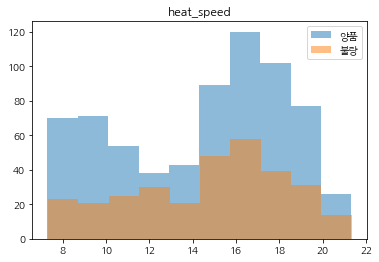

In [54]:
fun_plot_hist(df_speed, 'heat_speed')

In [55]:
X = df_speed['heat_speed']
y = df_speed['scale']
model_logistic = sm.Logit(y, sm.add_constant(X)).fit()
print(model_logistic.summary())

Optimization terminated successfully.
         Current function value: 0.618709
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      998
Method:                           MLE   Df Model:                            1
Date:                Tue, 07 Mar 2023   Pseudo R-squ.:               0.0006318
Time:                        13:40:14   Log-Likelihood:                -618.71
converged:                       True   LL-Null:                       -619.10
Covariance Type:            nonrobust   LLR p-value:                    0.3764
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0375      0.278     -3.729      0.000      -1.583      -0.492
heat_speed     0.0163      0.

- 유의하지 않은 컬럼이다. 
- 아주 큰 의미는 파악하지 못햇으나 12~13정도의 기울기를 가졌을 때의 불량률이 비교적 매우 높았던 점을 확인할 수 있었다.

In [56]:
df.corr()

,scale,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count
scale,1.000000,-0.098090,-0.189536,0.052115,0.222493,-0.035826,0.327817,-0.219581,-0.127695,0.510984,-0.040011
pt_thick,-0.098090,1.000000,-0.319894,-0.867125,-0.525317,0.206644,-0.665964,0.357260,0.338078,-0.446627,-0.845324
pt_width,-0.189536,-0.319894,1.000000,0.147979,0.200737,-0.100876,0.216879,-0.097273,-0.133329,-0.153727,0.350132
pt_length,0.052115,-0.867125,0.147979,1.000000,0.470846,-0.137895,0.603303,-0.333730,-0.276402,0.364767,0.818483
fur_heat_temp,0.222493,-0.525317,0.200737,0.470846,1.000000,-0.163792,0.787203,-0.373154,-0.313632,0.340433,0.488292
fur_heat_time,-0.035826,0.206644,-0.100876,-0.137895,-0.163792,1.000000,-0.349176,0.114804,0.736069,-0.131705,-0.166892
fur_soak_temp,0.327817,-0.665964,0.216879,0.603303,0.787203,-0.349176,1.000000,-0.596820,-0.560808,0.625106,0.627843
fur_soak_time,-0.219581,0.357260,-0.097273,-0.333730,-0.373154,0.114804,-0.596820,1.000000,0.632995,-0.486133,-0.399353
fur_total_time,-0.127695,0.338078,-0.133329,-0.276402,-0.313632,0.736069,-0.560808,0.632995,1.000000,-0.344617,-0.339263
rolling_temp,0.510984,-0.446627,-0.153727,0.364767,0.340433,-0.131705,0.625106,-0.486133,-0.344617,1.000000,0.312235


<AxesSubplot:>

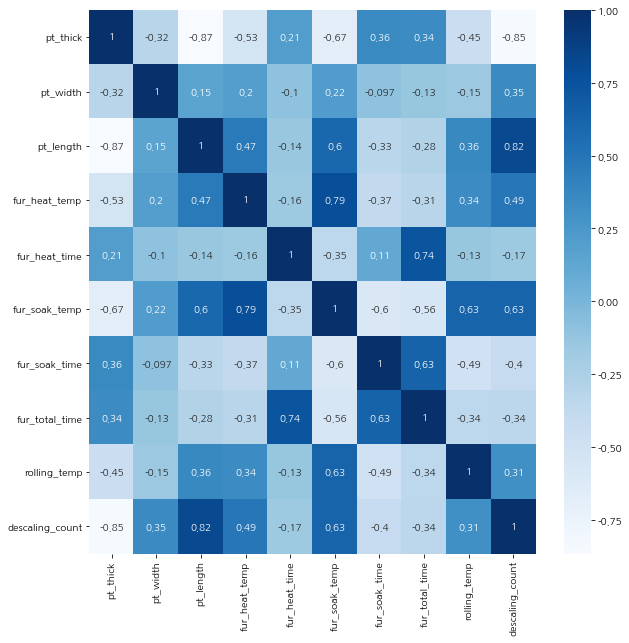

In [57]:
fig, axes = plt.subplots(figsize=(10,10))
sns.heatmap(df.drop('scale', axis=1).corr(), cmap="Blues", annot = True)

pt_thick, descaling_count 강한 음의 상관관계
pt_thick에 따라서 두꺼울수록 온도가 떨어지는 것 같음

# 모델링

- 사용 예정 모델 : 랜덤포레스트, XGBoost, LGBM 사용
    - GradientBoosting의 단점을 극복한 모델이 XGBoost이기 때문에 해당 모델 사용
    - CatBoost 같은 경우 연속형 설명변수가 많으면 성능이 저하될 수도 있기 때문에 해당 데이터와는 잘 맞지 않다고 판단

In [58]:
### 호열이라는 컬럼에 호기와 열 컬럼의 데이터가 포함되기 때문에 기존 두 컬럼 제외
df.drop(['fur_input_row', 'fur_no'], axis=1, inplace=True)
### 위에서 제거하기로 한 컬럼들은 그대로 다 제거할 예정
### 또한 추가적으로 work_group에서 교대로 파생변수를 만들었기 때문에 제거 예정
### 추후, dummy화 진행시 '교대' 컬럼을 선택하는게 더 컬럼 수를 줄일 수 있어서 성능 개선에 좋다고 판단
df.drop(['spec_long', '호열', 'pt_length', 'fur_heat_time','work_group'], axis=1, inplace=True)
df.head()

,scale,spec_country,steel_kind,pt_thick,pt_width,hsb,fur_heat_temp,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,교대
0,0,미국,T,32,3700,적용,1144,1133,59,259,TMCP(온도제어),934.0,8,1교대
1,0,미국,T,32,3700,적용,1144,1135,53,238,TMCP(온도제어),937.0,8,1교대
2,0,영국,T,33,3600,적용,1129,1121,55,258,TMCP(온도제어),889.0,8,1교대
3,0,영국,T,33,3600,적용,1152,1127,68,266,TMCP(온도제어),885.0,8,1교대
4,0,프랑스,T,38,3100,적용,1140,1128,48,246,TMCP(온도제어),873.0,8,1교대


In [59]:
### HSB도 적용 여부를 0, 1로 변환
df['hsb'] = df['hsb'].apply(lambda x: 1 if x == '적용' else 0)
### steel_kind도 티타늄일 경우 0, 탄소인 경우 1로 변환
df['steel_kind'] = df['steel_kind'].apply(lambda x: 1 if x == 'C' else 0)
### rolling_method도 TMCP일 경우 1, CR일 경우 0으로 변환
df['rolling_method'] = df.rolling_method.apply(lambda x: 1 if x == 'TMCP(온도제어)' else 0)
### 교대근무도 1교대는 0, 2교대는 1로 변환
df['교대'] = df.교대.apply(lambda x: 1 if x == '2교대' else 0)
df.head()

,scale,spec_country,steel_kind,pt_thick,pt_width,hsb,fur_heat_temp,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,교대
0,0,미국,0,32,3700,1,1144,1133,59,259,1,934.0,8,0
1,0,미국,0,32,3700,1,1144,1135,53,238,1,937.0,8,0
2,0,영국,0,33,3600,1,1129,1121,55,258,1,889.0,8,0
3,0,영국,0,33,3600,1,1152,1127,68,266,1,885.0,8,0
4,0,프랑스,0,38,3100,1,1140,1128,48,246,1,873.0,8,0


>> HSB 0: 미적용, 1: 적용
>> steel_kind 0: T, 1: C
>> rolling_method 0:CR, 1:TMCP
>> 교대근무 0: 1교대, 1: 2교대

In [60]:
### Scaling 같이 진행
### 트리 기반 알고리즘은 불필요하나 회귀 분석 진행 예정이라서 먼저 진행
stscaler = StandardScaler()
df_dummy = pd.get_dummies(df)
df_x = df_dummy.drop('scale', axis=1)
df_y = df_dummy['scale']

scaled_df_x = stscaler.fit_transform(df_x)

train_x, test_x, train_y, test_y = train_test_split(scaled_df_x, df_y, test_size=0.3)

#### 모델 선언

In [61]:
rf = RandomForestClassifier()
rf.fit(train_x, train_y);

xgb = XGBClassifier()
xgb.fit(train_x,train_y);

lgbm =LGBMClassifier()
lgbm.fit(train_x, train_y)

[13:40:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


LGBMClassifier()

In [62]:
print("랜덤포레스트 모델 train 정확도 : ",rf.score(train_x,train_y))
print("랜덤포레스트 모델 test 정확도 : ", rf.score(test_x,test_y))
print()
print("XGB 모델 train 정확도 : ", xgb.score(train_x,train_y))
print("XGB 모델 test 정확도 : ", xgb.score(test_x,test_y))
print()
print("LBGM 모델 train 정확도 : ", lgbm.score(train_x,train_y))
print("LGBM 모델 test 정확도 : ", lgbm.score(test_x,test_y))

랜덤포레스트 모델 train 정확도 :  1.0
랜덤포레스트 모델 test 정확도 :  0.9566666666666667

XGB 모델 train 정확도 :  1.0
XGB 모델 test 정확도 :  0.9866666666666667

LBGM 모델 train 정확도 :  1.0
LGBM 모델 test 정확도 :  1.0


- 여러 모델 중 기본 파라미터 이용시에 XGB 모델의 성능이 제일 높다고 판단. 왜냐하면, LGBM에서 test에 관한 성능이 1.0이 나온 것은 오히려 문제라고 판단.
- XGB의 파라미터를 조정해 모델의 성능을 향상하려고 함

In [63]:
eval_df = [(test_x, test_y)]
xgb_stop = XGBClassifier(n_estimators=300, learning_rate=0.1,max_depth=6)
xgb_stop.fit(train_x,train_y,early_stopping_rounds=150, eval_metric="logloss",eval_set=eval_df, verbose=True)

print("최적 횟수: ", xgb_stop.best_iteration)
print("최적 성능(0-LogLoss): ",xgb_stop.best_score)

[0]	validation_0-logloss:0.60649
[1]	validation_0-logloss:0.53518
[2]	validation_0-logloss:0.47533
[3]	validation_0-logloss:0.42489
[4]	validation_0-logloss:0.38182
[5]	validation_0-logloss:0.34457
[6]	validation_0-logloss:0.31234
[7]	validation_0-logloss:0.28445
[8]	validation_0-logloss:0.26030
[9]	validation_0-logloss:0.23917
[10]	validation_0-logloss:0.22040
[11]	validation_0-logloss:0.20410
[12]	validation_0-logloss:0.18996
[13]	validation_0-logloss:0.17629
[14]	validation_0-logloss:0.16497
[15]	validation_0-logloss:0.15413
[16]	validation_0-logloss:0.14463
[17]	validation_0-logloss:0.13651
[18]	validation_0-logloss:0.12946
[19]	validation_0-logloss:0.12089
[20]	validation_0-logloss:0.11325
[21]	validation_0-logloss:0.10654
[22]	validation_0-logloss:0.10054
[23]	validation_0-logloss:0.09525
[24]	validation_0-logloss:0.09052
[25]	validation_0-logloss:0.08660
[26]	validation_0-logloss:0.08281
[27]	validation_0-logloss:0.07946
[28]	validation_0-logloss:0.07673
[29]	validation_0-loglos

In [64]:
xgb_pred_stop=xgb_stop.predict(test_x)

print("\n 조기 중단 모델 평가: Test\n")
eval_class_model(test_y,xgb_pred_stop)
print('\n',classification_report(test_y, xgb_pred_stop))


 조기 중단 모델 평가: Test

오차행렬:
 [[206   0]
 [  3  91]] 

정확도:0.9900
정밀도: 1.0000
재현율: 0.9681
F1    : 0.9838
AUC   : 0.9840

               precision    recall  f1-score   support

           0       0.99      1.00      0.99       206
           1       1.00      0.97      0.98        94

    accuracy                           0.99       300
   macro avg       0.99      0.98      0.99       300
weighted avg       0.99      0.99      0.99       300



In [69]:
#여기서 설정 파라미터의 갯수(총 4000개의 조합이므로 4000번의 학습이 돌아감)
xgb_param_grid={
    'n_estimators' : [100,200,300,400,500],
    'learning_rate' : [0.01,0.05,0.1,0.15],
    'max_depth' : [3,5,7,10,15],
    'gamma' : [0,1,2,3],
    'colsample_bytree' : [0.8,0.9],
    
}
xgb_grid=GridSearchCV(xgb, param_grid = xgb_param_grid, scoring="f1_macro", n_jobs=-1, verbose = 2)
xgb_grid.fit(train_x, train_y)

#best f1_macro 수치와 best parameter확인
print("best f1_macro : {0: .4f}".format(xgb_grid.best_score_))
print("best param : ",xgb_grid.best_params_)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits
[14:06:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
best f1_macro :  0.9916
best param :  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.15, 'max_depth': 10, 'n_estimators': 200}


In [70]:
### grid_search 모델 평가
xgb_grid_best = xgb_grid.best_estimator_
xgb_pred_grid=xgb_grid_best.predict(test_x)
eval_class_model(test_y,xgb_pred_grid)
print('\n',classification_report(test_y, xgb_pred_grid))

오차행렬:
 [[205   1]
 [  3  91]] 

정확도:0.9867
정밀도: 0.9891
재현율: 0.9681
F1    : 0.9785
AUC   : 0.9816

               precision    recall  f1-score   support

           0       0.99      1.00      0.99       206
           1       0.99      0.97      0.98        94

    accuracy                           0.99       300
   macro avg       0.99      0.98      0.98       300
weighted avg       0.99      0.99      0.99       300



In [65]:
v_feature_name = df_x.columns
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = xgb_stop.feature_importances_ # model.feature_importances_로 설명변수 중요도 확인 및 테이블 저장

df_importance.sort_values("Importance", ascending = False , inplace = True) # 변수의 중요도별로 정렬
df_importance.round(5).head(20)

,Feature,Importance
3,hsb,0.41788
9,rolling_temp,0.32029
5,fur_soak_temp,0.11574
1,pt_thick,0.07982
15,spec_country_영국,0.01529
10,descaling_count,0.01348
7,fur_total_time,0.01229
2,pt_width,0.00737
4,fur_heat_temp,0.00579
6,fur_soak_time,0.00541


Text(0, 0.5, '설명변수')

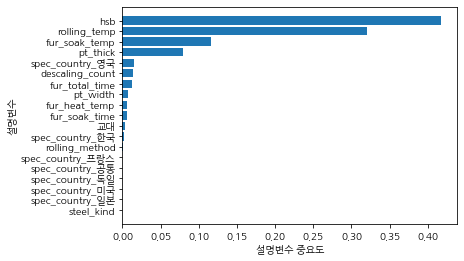

In [66]:
df_importance.sort_values("Importance", ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

- hsb, rolling_temp, fur_soak_temp, descaling_count 등의 중요도가 높이 나왔다. 주문 내역 같은 경우는 컨트롤할 수 있는 변수가 아니라고 판단
- 온도 조절 및 추가 가공을 해야 한다는 위에서의 판단이 맞다고 증명됨.